# Recommender system

中国人民大学 秦晋琦 2018103664

In [ ]:
# auther: qinjiqi 2018103664
# spark 2.4.0
# python 3.6.4
# -*- coding: utf-8 -*- 

In [1]:
from pyspark.sql import SparkSession
import numpy as np

In [2]:
# 初始化
sc = SparkSession.builder.appName("Moviwlens Recommendation").getOrCreate()

In [3]:
# 将三个数据集读取为RDD，并展示首行
path = '/ml-100k'
user_data = sc.sparkContext.textFile(str(path) + "/u.user")
movie_data = sc.sparkContext.textFile(str(path) + "/u.item")
rating_data = sc.sparkContext.textFile(str(path) + "/u.data")
print(user_data.first())
print('\t')
print(movie_data.first())
print('\t')
print(rating_data.first())

1|24|M|technician|85711
	
1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
	
196	242	3	881250949


### 对用户信息的描述性统计

In [4]:
# 统计用户各属性的数量
user_field = user_data.map(lambda line: line.split('|'))
user_num = user_field.map(lambda x: x[0]).count()
user_gender = user_field.map(lambda x: x[2]).distinct().count()
user_occupation = user_field.map(lambda x: x[3]).distinct().count()

In [5]:
print('用户数：%d, 性别数：%d, 职业种类：%d' % (user_num,user_gender,user_occupation))

用户数：943, 性别数：2, 职业种类：21


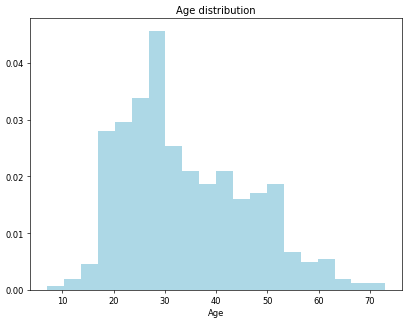

In [7]:
# Plot age distribution
import matplotlib.pyplot as plt
ages = user_field.map(lambda x: int(x[1])).collect()
plt.figure(figsize=(8,6),dpi=60)
plt.hist(ages, bins=20, color='lightblue',normed=True)
plt.title('Age distribution')
plt.xlabel('Age')
plt.savefig('./pics/1.jpg', format='jpg',dpi = 500,bbox_inches='tight')
plt.show()

In [45]:
# 年龄分布统计
user_field.map(lambda x: int(x[1])).stats()

(count: 943, mean: 34.05196182396604, stdev: 12.186273150937206, max: 73.0, min: 7.0)

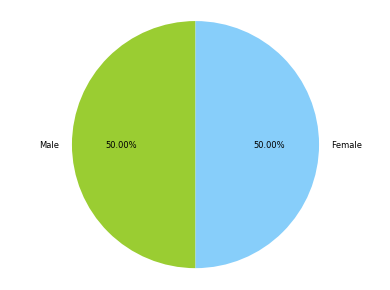

In [55]:
# Plot Gender Pie plot
plt.figure(figsize=(8,6),dpi=60)
gender = user_field.map(lambda x: x[2]).distinct().collect()
M = user_field.map(lambda x: x=='M').count()
F = user_field.map(lambda x: x=='F').count()
sizes = [M,F]
labels = ['Male','Female']
colors = ['yellowgreen','lightskyblue']
explode=[0,0]
plt.pie(sizes,
        explode=explode,
        labels=labels,
        colors=colors,
        autopct = '%3.2f%%',
        shadow = False, 
        startangle =90, 
        pctdistance = 0.6)
plt.axis('equal')
plt.savefig('./pics/2.jpg', format='jpg',dpi = 500,bbox_inches='tight')
plt.show()

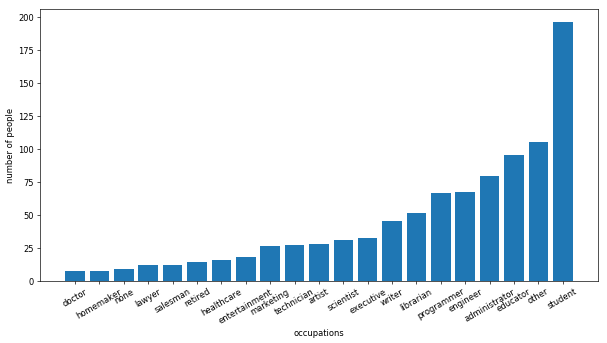

In [27]:
# Plot occupation
count_by_occupation = user_field.map(lambda x: (x[3],1)).reduceByKey(lambda x,y: x+y).collect() #返回的是一个键值对的list
plt.figure(figsize=(12,6),dpi=60)
ylab = np.array([i[1] for i in count_by_occupation])
values = ylab[np.argsort(ylab)] #排序
xlab = np.array([i[0] for i in count_by_occupation])
xlab = xlab[np.argsort(ylab)]
index = np.arange(len(xlab)) + 0.5
plt.bar(index,values)
plt.xticks(index,xlab,rotation=30)
plt.xlabel('occupations')
plt.ylabel('number of people')
plt.savefig('./pics/3.jpg', format='jpg',dpi = 500,bbox_inches='tight')
plt.show()

### 对电影数据的描述性统计

In [47]:
# 简单查看下有多少部电影参与评分
movie_num = movie_data.count()
print(movie_num)

1682


### 对评分信息的描述性统计

In [29]:
rating_field = rating_data.map(lambda line: line.split('\t'))

In [30]:
rating_field.first()

['196', '242', '3', '881250949']

In [46]:
# 共有多少条评分数据
rating_num = rating_field.count()
print(rating_num)

100000


In [44]:
# 打分情况统计
score = rating_field.map(lambda x: int(x[2]))
score.stats()

(count: 100000, mean: 3.529859999999947, stdev: 1.1256679707622548, max: 5.0, min: 1.0)

In [51]:
# 平均每个人评了多少部电影以及每部电影平均得到了几个评分，从中我们可以看出打分矩阵的稀疏性
print("平均每人评价 %f" % (rating_num/user_num), "部电影")
print("平均每部电影有 %f" % (rating_num/movie_num), "个评分")

平均每人评价 106.044539 部电影
平均每部电影有 59.453032 个评分


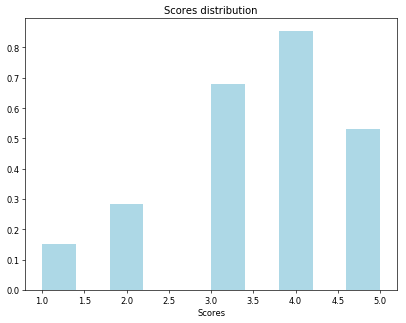

In [32]:
# 看一下所有打分的分布情况
plt.figure(figsize=(8,6),dpi=60)
plt.hist(score, color='lightblue',normed=True)
plt.title('Scores distribution')
plt.xlabel('Scores')
plt.savefig('./pics/4.jpg', format='jpg',dpi = 500,bbox_inches='tight')
plt.show()

### 算法实现

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np

In [2]:
# 加载mllib中用于协同过滤计算的算法包ALS以及数据格式要求Rating
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [3]:
# 初始化sc
sc = SparkSession.builder.appName("Moviwlens Recommendation").getOrCreate()

In [4]:
# 将数据读入为RDD，正确分割并转换成Rating格式（ALS只接受rating格式输入）
path = '/ml-100k'
ratings = sc.sparkContext.textFile(str(path) + '/u.data').map(lambda x: x.split('\t')).map(
    lambda x: Rating(int(x[0]),int(x[1]),float(x[2])))

In [75]:
# 电影数据读成DF格式
movies = sc.sparkContext.textFile(str(path) + '/u.item').map(
    lambda x: x.split('|')).map(lambda x: Row(int(x[0]),x[1])).toDF(["movieID","title"])

In [69]:
movies = sc.sparkContext.textFile(str(path) + '/u.item').map(
    lambda x: x.split('|')).map(lambda x: Rating(int(x[0]),x[1])) 

In [71]:
movies

PythonRDD[298] at RDD at PythonRDD.scala:53

In [7]:
ratings.first()

Rating(user=196, product=242, rating=3.0)

In [20]:
ratings

PythonRDD[223] at RDD at PythonRDD.scala:53

In [8]:
# 区分训练集和测试集
train, test = ratings.randomSplit([0.7,0.3])

In [9]:
train

PythonRDD[13] at RDD at PythonRDD.scala:53

In [10]:
# training
model = ALS.train(train,rank=50,iterations=10)

In [11]:
model

In [16]:
model.userFeatures

<bound method MatrixFactorizationModel.userFeatures of <pyspark.mllib.recommendation.MatrixFactorizationModel object at 0x7faa609f3278>>

In [26]:
# 预测针对某个用户该如何推荐
userID = 555
K = 10
topKRecs = model.recommendProducts(userID, K)

In [63]:
topKRecs

[Rating(user=555, product=423, rating=6.013670745175982),
 Rating(user=555, product=694, rating=5.851447198404916),
 Rating(user=555, product=65, rating=5.744001083036378),
 Rating(user=555, product=521, rating=5.661764115881104),
 Rating(user=555, product=100, rating=5.560300209104002),
 Rating(user=555, product=781, rating=5.5473357944816195),
 Rating(user=555, product=170, rating=5.519945395263284),
 Rating(user=555, product=576, rating=5.506372240787474),
 Rating(user=555, product=209, rating=5.472697469955474),
 Rating(user=555, product=1137, rating=5.46494430552012)]

In [77]:
# 在预测结果中加上电影名
def recommend_for_one_user(model, user_id, K):
    b_movies = sc.sparkContext.broadcast(dict((int(l[0]), l[1]) for l in movies.collect()))
    recommendations = model.recommendProducts(user_id, K)
    result = []
    for item in recommendations:
        result.append((b_movies.value[item.product], item.rating))
    print ("Top %d Recommendations for user "% K, user_id, ": ", result)

In [78]:
recommend_for_one_user(model,555,10)

Top 10 Recommendations for user  555 :  [('E.T. the Extra-Terrestrial (1982)', 6.013670745175982), ('Persuasion (1995)', 5.851447198404916), ("What's Eating Gilbert Grape (1993)", 5.744001083036378), ('Deer Hunter, The (1978)', 5.661764115881104), ('Fargo (1996)', 5.560300209104002), ('French Kiss (1995)', 5.5473357944816195), ('Cinema Paradiso (1988)', 5.519945395263284), ('Cliffhanger (1993)', 5.506372240787474), ('This Is Spinal Tap (1984)', 5.472697469955474), ('Beautiful Thing (1996)', 5.46494430552012)]


In [90]:
# 输出对所有人的预测结果：给每位用户推荐10部电影
def recommend_for_all(model, movies, result_path, file_out_flag=False):
    def parse_recommendations(line):
        res = []
        for item in line[1]:
            movie_name = b_movies.value[item[1]]
            res.append((movie_name, float(item[2])))
        return Row(user=line[0], recommendations=res)

    b_movies = sc.sparkContext.broadcast(dict((int(l[0]), l[1]) for l in movies.collect()))
    products_for_all_users = model.recommendProductsForUsers(10).map(parse_recommendations).toDF()
    recommendation_result = products_for_all_users.repartition(1).orderBy(products_for_all_users.user).rdd \
        .map(lambda l: Row(str(l.user) + "," + str(list((r[0], r[1]) for r in l.recommendations))))\
        .toDF().repartition(1)
    if file_out_flag:  # 输出到文件
        recommendation_result.write.text(result_path)
    print(type(recommendation_result))

In [92]:
file_out_flag = True
recommend_for_all(model,movies,'/result.txt',file_out_flag)

<class 'pyspark.sql.dataframe.DataFrame'>


In [80]:
# evaluation
# 采用MSE来进行评价
testdata = test.map(lambda x: (x[0],x[1]))
prediction = model.predictAll(testdata).map(lambda x: ((x[0],x[1]),x[2]))
ratesAndPreds = ratings.map(lambda x: ((x[0],x[1]),x[2])).join(prediction)
MSE = ratesAndPreds.map(lambda x: (x[1][0]-x[1][1])**2).mean()
RMSE = MSE**(0.5)
print("MSE of testing data is: %f" % MSE)
print("RMSE of testing data is: %f" % RMSE)

MSE of testing data is: 1.534182
RMSE of testing data is: 1.238621
